In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
random.seed(0)

# 1. Synthetic Parallel Dataset

In [3]:
subjects = ["i", "you", "we", "they"]
verbs = ["like", "love", "hate", "see"]
objects = ["cats", "dogs", "books", "coffee"]

fr_subjects = {"i":"je", "you":"tu", "we":"nous", "they":"ils"}
fr_verbs = {"like":"aime", "love":"adore", "hate":"deteste", "see":"vois"}
fr_objects = {"cats":"chats", "dogs":"chiens", "books":"livres", "coffee":"cafe"}

pairs = []
for _ in range(300):
    s, v, o = random.choice(subjects), random.choice(verbs), random.choice(objects)
    pairs.append((f"{s} {v} {o}",
                  f"{fr_subjects[s]} {fr_verbs[v]} {fr_objects[o]}"))

def tokenize(x): return x.split()

src_vocab = {"<pad>":0, "<s>":1, "</s>":2}
tgt_vocab = {"<pad>":0, "<s>":1, "</s>":2}

for src, tgt in pairs:
    for w in tokenize(src):
        if w not in src_vocab: src_vocab[w] = len(src_vocab)
    for w in tokenize(tgt):
        if w not in tgt_vocab: tgt_vocab[w] = len(tgt_vocab)

def encode(sent, vocab):
    return [vocab["<s>"]] + [vocab[w] for w in tokenize(sent)] + [vocab["</s>"]]

data = [(encode(s, src_vocab), encode(t, tgt_vocab)) for s, t in pairs]



# 2. Encoder (Bidirectional GRU)

In [5]:
class Encoder(nn.Module):
    def __init__(self, V, E, H):
        super().__init__()
        self.emb = nn.Embedding(V, E)
        self.fwd = nn.GRU(E, H, batch_first=True)
        self.bwd = nn.GRU(E, H, batch_first=True)

    def forward(self, x):
        e = self.emb(x)
        f, _ = self.fwd(e)
        b, _ = self.bwd(torch.flip(e, [1]))
        b = torch.flip(b, [1])
        return torch.cat([f, b], dim=2)

# 3. Bahdanau Attention

In [7]:
class Attention(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.W = nn.Linear(H, H, bias=False)
        self.U = nn.Linear(2*H, H, bias=False)
        self.v = nn.Linear(H, 1, bias=False)

    def forward(self, s, h, return_alpha=False):
        T = h.size(1)
        s = s.unsqueeze(1).repeat(1, T, 1)
        e = self.v(torch.tanh(self.W(s) + self.U(h))).squeeze(2)
        alpha = F.softmax(e, dim=1)
        c = (alpha.unsqueeze(2) * h).sum(1)
        return (c, alpha) if return_alpha else c

# 4. Decoder


In [9]:
class Decoder(nn.Module):
    def __init__(self, V, E, H):
        super().__init__()
        self.emb = nn.Embedding(V, E)
        self.gru = nn.GRU(E + 2*H, H, batch_first=True)
        self.out = nn.Linear(H, V)

    def forward(self, y, s, c):
        e = self.emb(y)
        x = torch.cat([e, c.unsqueeze(1)], dim=2)
        o, s = self.gru(x, s.unsqueeze(0))
        return self.out(o.squeeze(1)), s.squeeze(0)

# 5. Full NMT Model


In [11]:
class NMT(nn.Module):
    def __init__(self, srcV, tgtV, E=32, H=64):
        super().__init__()
        self.enc = Encoder(srcV, E, H)
        self.att = Attention(H)
        self.dec = Decoder(tgtV, E, H)

    def forward(self, src, tgt):
        h = self.enc(src)
        s = torch.zeros(1, h.size(2)//2)
        y = tgt[:,0].unsqueeze(1)
        loss = 0
        for t in range(1, tgt.size(1)):
            c = self.att(s, h)
            logits, s = self.dec(y, s, c)
            loss += F.nll_loss(F.log_softmax(logits,1), tgt[:,t])
            y = tgt[:,t].unsqueeze(1)
        return loss

# 6. Training + Per-Sentence Loss Tracking


In [13]:
model = NMT(len(src_vocab), len(tgt_vocab))
opt = torch.optim.Adam(model.parameters(), lr=0.01)

sentence_losses = {i:[] for i in range(10)}

for epoch in range(200):
    for i, (src, tgt) in enumerate(data[:10]):
        src = torch.tensor(src).unsqueeze(0)
        tgt = torch.tensor(tgt).unsqueeze(0)
        opt.zero_grad()
        loss = model(src, tgt)
        loss.backward()
        opt.step()
        sentence_losses[i].append(loss.item())

# 7. Visualization 1: Per-Sentence Loss


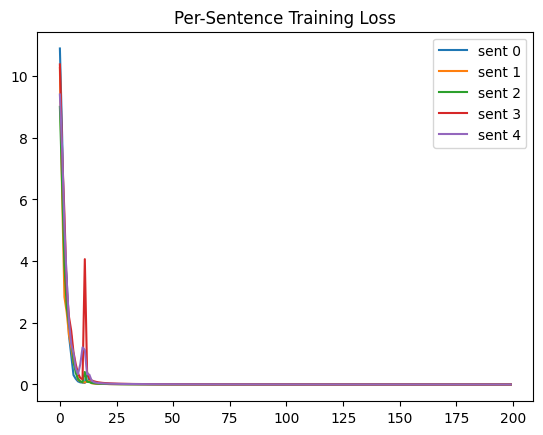

In [19]:
for i in range(5):
    plt.plot(sentence_losses[i], label=f"sent {i}")
plt.legend()
plt.title("Per-Sentence Training Loss")
plt.show()

# 8. Translation with Attention Probes


In [23]:
def translate(sentence):
    src = torch.tensor(encode(sentence, src_vocab)).unsqueeze(0)
    h = model.enc(src)
    s = torch.zeros(1, h.size(2)//2)
    y = torch.tensor([[tgt_vocab["<s>"]]])

    attn, norms, out = [], [], []

    for _ in range(5):
        c, a = model.att(s, h, True)
        norms.append(torch.norm(s).item())
        logits, s = model.dec(y, s, c)
        w = logits.argmax(1).item()
        if w == tgt_vocab["</s>"]: break
        out.append(w)
        attn.append(a[0].detach().numpy())
        y = torch.tensor([[w]])

    return out, attn, norms, src[0]

# 9. Visualization Utilities


In [25]:
def plot_attention(attn, src, tgt):
    plt.imshow(np.stack(attn), cmap="viridis")
    plt.xticks(range(len(src)), [k for k,v in src_vocab.items() if v in src], rotation=45)
    plt.yticks(range(len(tgt)), [k for k,v in tgt_vocab.items() if v in tgt])
    plt.title("Attention Heatmap")
    plt.colorbar()
    plt.show()

# 10. Run Visual Diagnostics


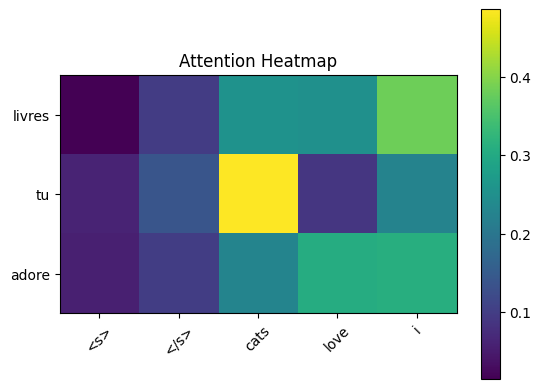

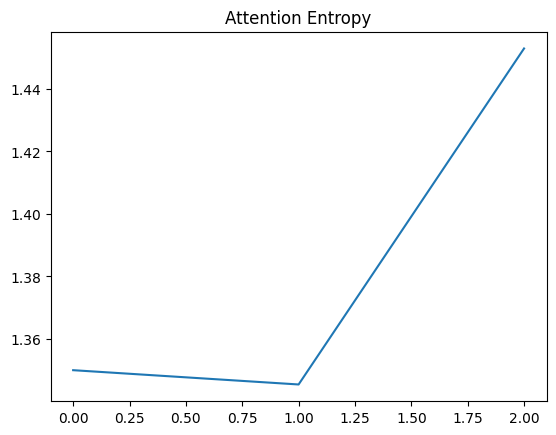

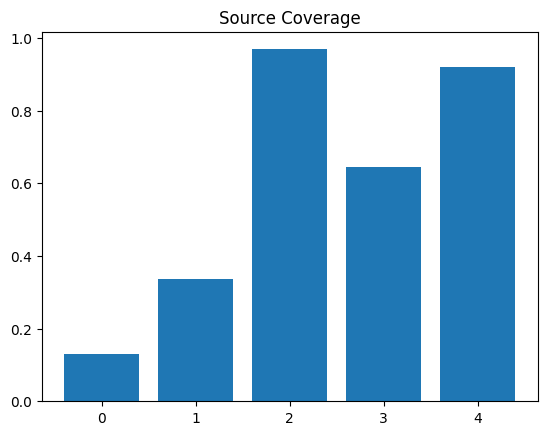

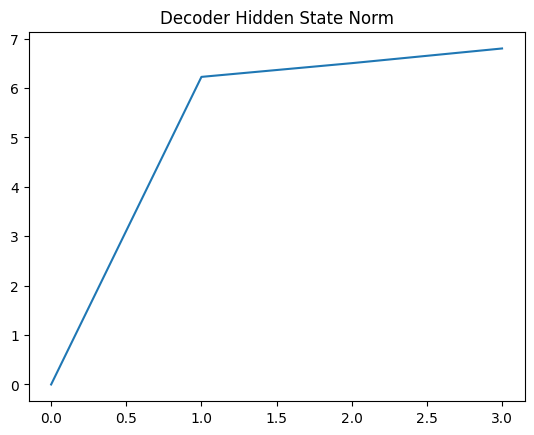

In [27]:
out, attn, norms, src = translate("i love cats")

# Attention heatmap
plot_attention(attn, src, out)

# Attention entropy
entropy = [-(a*np.log(a+1e-9)).sum() for a in attn]
plt.plot(entropy)
plt.title("Attention Entropy")
plt.show()

# Source coverage
coverage = np.sum(np.stack(attn), axis=0)
plt.bar(range(len(coverage)), coverage)
plt.title("Source Coverage")
plt.show()

# Decoder hidden state norm
plt.plot(norms)
plt.title("Decoder Hidden State Norm")
plt.show()